In [1]:
from audioeqinfer import EQ_finder, f_X, ParameterFunction
from audioeqinfer.utils import show_audio_with_controls, fft_diagram, EQ_FILE
import numpy as np
import matplotlib.pyplot as plt
from pedalboard.io import AudioFile


# AudioEqInfer Exploration Notebook
This project is a study around the connections between topics learned in STA410 and ideas behind music production. In particular, I use  three ideas to explore three musical/statistical/computational problems.

- I explore approximation limitations of fft, such as base resolution. Using an audioeqinfer utility that visualizes frequency bands.

- I demonstrate a utility that allows you to equalize a track using arbitrary functions.

- I then demonstrate the main use of audioeqinfer:  Reconstructing an EQ function using normal flows and Metropolis Hastings algorithm.

This notebook explores the elements and experiments I ran as I added to the package. 


IMPORTANT!!:
- Please run the cells of this notebook as you go through, rather than all at once, since I overwrite the file "output.wav" a few times to demonstrate different things.
- It also would be worth listening with headphones or monitors, so that you can hear some of the nuance in the sound.
- START WITH VOLUME LOW!!!

## Introduction to EQ and other Musical Ideas
If you are asking "What is EQ?" see:  https://en.wikipedia.org/wiki/Equalization_(audio)
Essentially a parametric equalizer is a tool that allows an audio engineer to change the volume of certain frequencies in a sound signal. This invention revolutionized music production in the early 1970s.

Here's an excellent intro to understanding and visualizing how eq works: https://www.youtube.com/watch?v=I6ZF_NHvqzU.

Remember when STATS410 discussed the fast fourier transform principles? Well we can use this to build a parametric eq software!

Most commercial software EQ's extend significantly beyond this basic design (see: https://www.meldaproduction.com/tutorials/text/equalizers#fft). This is for a bunch of reasons, including:
 - Live audio computational requirements
 - "poor bass resolution" which is a consequence of the Nyquist-Shannon sampling theorem (see: https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), which we will explore in greater depth.


## Generating audio with pedalboard:
Pedalboard (see: https://github.com/spotify/pedalboard) is an awesome audio processing library that is extremely fast, pythonic, and used throughout this notebook and in audioeqinfer.

In [2]:
# Generate a sound signal (mono)
samplerate = 44100
duration = 1
with AudioFile("normal.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.normal(0, 1, (1,samplerate*duration)))


In [3]:
show_audio_with_controls("normal.wav")


normal.wav


## Visualizing Frequency Domain
This demonstrates the power of AudioEqInfer's fft_diagram, which is a spectrum analizer that visualizes frequencies within the range of human hearing, which is roughly 20-22000 Hz

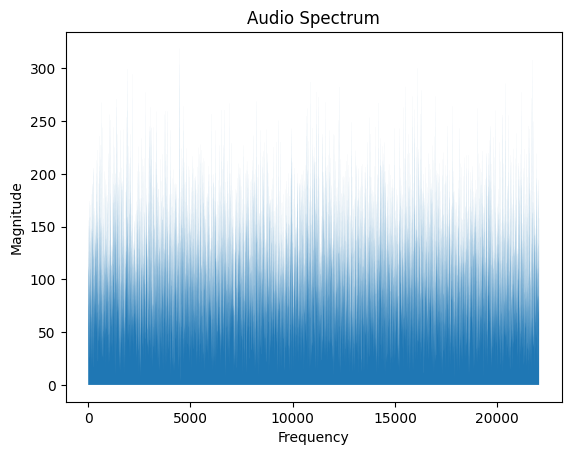

In [4]:
duration = 0.5
with AudioFile("normal.wav") as af:
    file = af.read(af.samplerate*duration)[0]

#return magnitude, freq
fft_diagram(file, samplerate)

Mixing consoles often use a linear fft analyzer to help quickly identify frequencies that cause problems during live concerts! 

In general, producers try not to rely on visualization, because of low bass resolution, which is a mathematical consequence of the fast fourier transform being an approximation that doesn't account for all possible frequencies. This effect is similar to STAT410 material around the approximation of floating point numbers. Just like how floating point approximation of real numbers get worse as real numbers get further from 0, the fourier transform approximations get worse as our real world frequencies approach zero. It's really cool that audio people have instinctively internalized this mathematical context using their ears.

You can visualize the effects of bass resolution by experimenting with the cell below. 
Which generates a sine wave at a given frequency, writes it to an audiofile, then reads and visualizes the returned wav file.
In theory a sinewave transformed into frequency space should consist of just one spike at the magnitude of the proper frequency. However this is not what occurs in many of our approximations.

This also demonstrates how audioeqinfer.fft_diagram has been designed to pass arbitrary arguments to matplotlib. In this case we use this functionality to visualize on the log scale.

I recommend experimenting with sinewaves at 80, 85, 440,and 445 Hz.
Notice how the 85Hz approximation is significantly worse than the 445Hz approximation.

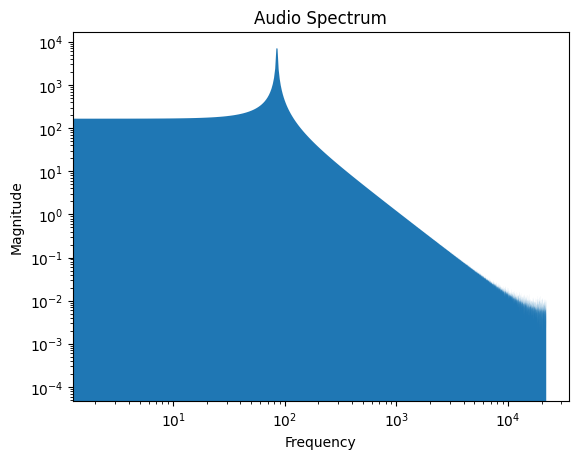

In [5]:
duration = 0.5
#TODO little buttons
frequency = 85 #compare 80,85,440,445 which is magnitudes greater than it's spike
with AudioFile("BassSine.wav", samplerate=samplerate, num_channels=1) as af:
    af.write(np.sin(2*np.pi*frequency*np.arange(samplerate*duration)/samplerate))

with AudioFile("BassSine.wav") as af:
    audio = af.read(af.samplerate*duration)[0]
    a = fft_diagram(audio, af.samplerate, xscale = "log",yscale ="log")

## Using AudioEQInfer's Parametric EQ

Now that we've discussed approximation issues with FFT, and shown the visualization utility of audioeqinfer, lets demonstrate how AudioEqInfer's parametric EQ modules work.

There are two modules that make up AudioEQInfer's parametric EQ functionality, **EQ_FILE**, and **ParameterFunction**

**EQ_FILE** is a function in the utility module and takes three arguments, input file path, output file path, and an arbitrary function *g*. The function *g* is a function that takes a frequency on the domain of hearable audio and returns a multiplier for the magnitude of the signal at that given frequency. For intended functionality the codomain of *g* should be within the set of positive floating point numbers.

**ParameterFunction** is a class representing a highly expressive function built out of bsplines, designed expressly with the purpose of being used with the EQ_File utility. Its basic functionality allows for setting 502 individual parameters, which act as coeffients for basis splines, covering all frequencies within human hearing. Flexibility is included for more or less parameters, and going beyond human hearing range. Additionally, the class contains functions for fitting the parameters to data, and visualization.

*Note: Increasing and decreasing volume is inherently multiplicative. The very measure of volume is the decibel, which is a logarithmic scale. When you look at a mixing console dial and see +2db, you are multiplying the magnitude signal. https://en.wikipedia.org/wiki/Decibel*

In [6]:
#this example lowers volume across all frequencies
g = lambda x: 0.1
f1, f2 = "normal.wav", "output.wav"
EQ_FILE(f1, f2, g)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

normal.wav


output.wav


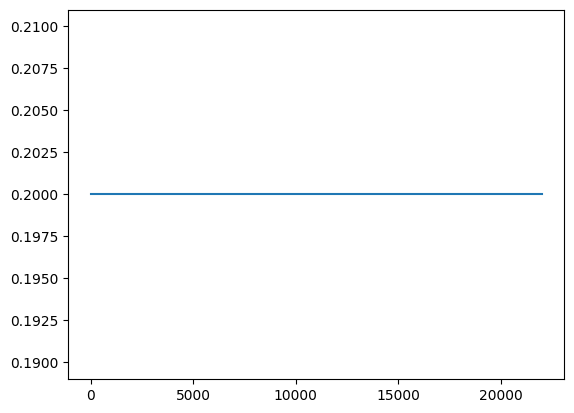

/home/widea/ProjectsWithOwnVenv/audioeqinfer/.venv/lib/python3.13/site-packages/scipy/interpolate/_fitpack_impl.py:323: ComplexWarning: Casting complex values to real discards the imaginary part
  y, ier = dfitpack.splev(t, c, k, x, ext)


normal.wav


output.wav


In [7]:
#This example demonstrates the same, but using our parameter function
eq = ParameterFunction()
eq.set_coefficients(np.array([0.2]*(eq.number_of_coefficients_needed())))
eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

The cell below demonstrates using ParameterFunction and EQ_FILE to turn our normal signal ("White noise") into 1/f noise or "pink noise" https://en.wikipedia.org/wiki/Pink_noise. This type of signal has deep connections mathematically to biological systems, frequency of moon crater impact sizes and gravitational waves. It also sounds nice. Hence it is occasionally used as reference audio when mixing tracks https://www.soundonsound.com/techniques/mixing-pink-noise-reference.

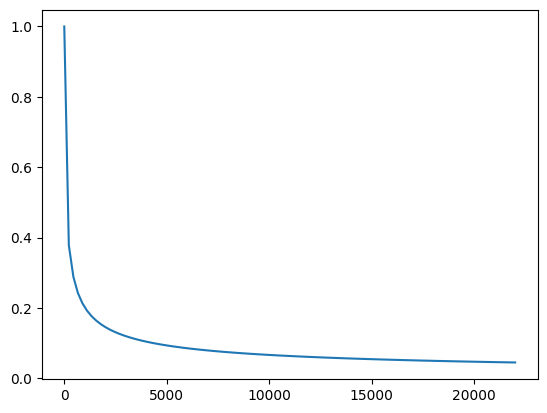

normal.wav


output.wav


In [8]:
eq = ParameterFunction()
b = np.array([1/x**0.5 for x in range(1,eq.number_of_coefficients_needed()+1)])
eq.set_coefficients(b)
eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)


## Finally, the central problem: getting back an Equalizer's parameters

The above explorations are wonderful and interesting in their own ways. However, these utilities are included in the audioeqinfer package as help for studying the package's motivating problem. If a signal is distorted by EQ, how can we get back the original eq function?

### Illustrating Example:
 Imagine you know in general what sound from a specific source sounds like — for example the way a specific person's voice sounds. If you heard an EQ distorted recording of this person's voice, you would know it had been altered in some way. If you are not an audio engineer you may not have the vocabulary to translate this into exact parameters; a person with no experience would use terms like "the esses sound too harsh", "It sounds too boxy", "it sounds too honking". The central observation is that it isn't nessecary to have already heard the exact signal that was distorted, it is sufficient to just have heard signals from the source before. Audioeqinfer replicates this capacity using statistical tools.

### Problem set up:
audioeqinfer uses two classes: **EQ_finder** and **f_X**. It works by analyzing audio signals as little slices in frequency space over time.

~~~
    |  |  |  |  |
    x1 x2 x3 x4 x5
    |  |  |  |  |
    --------------> time
~~~
The **f_X**  is a representation of the signal source (like a car engine, or someone's voice). Specifically, it represents the probability density function of frequency space slices. For a matrix of these slices, f_X.logprob outputs the log probability of x1 occuring naturally from the signal source. The f_X class represents this using normalized flows, however **EQ_finder** allows for any representations that appropriately output pdf logprobs from a matrix of x slices.

**EQ_finder** takes an audio signal that has been distorted by eq, as well as a statistical representation of the original signal source, and gets back the parameters of the eq by sampling from parameter space based on two possible methods. Firstly, an importance sampling method that reweights parameters based on f_X, and a version using Metropolis Hastings. The Metropolis Hastings algorithm is by far the more effective.


### Mathematizing
$\Theta$ : is the space of possible eq parameters. $\theta$ being a given parameter vector.

$X'$: is the space of possible observations for the frequency time output signal after EQ edits. $x'$ is a matrix of actual observations (we ignore order). $x'_t$ being the vector of the magnitude of the frequencies from fft at time t.

$X$: is the space of possible input signals (real signals). $x$ is the actual underlying signal.

We want to know $E(\theta|x')$.

#### What we know

$x' = g_\theta(x )$ where $X \bot \Theta$ and $g$ is 1:1

We can figure out that:

$$f_{X'}(x') = \int_\Theta  f_X'(x'|\theta) f_\Theta (\theta) = \int_\Theta  f_X(g_\theta^{-1}(x')) f_\Theta (\theta)$$
Since:

$$f_{X'|\Theta}(x'|\theta) = \int_X\begin{cases} 1 & g_\theta(x) = x' \\  0 & g_\theta(x) \neq x' \end{cases} f_{X}(x) = f_X(g^{-1}_\theta(x'))$$


And thus: 
$$f_{\Theta|X'}(\theta|x') = \frac{f_{X'|\Theta}(x'|\theta) f_\Theta (\theta)}{f_{x'}(x')} = \frac{f_X(g^{-1}_\theta(x')) f_\Theta (\theta)}{\int_\Theta f_X(g^{-1}(x')) f_\Theta (\theta)}$$

Which proves that given an underlying model of the signal source ($f_X$) we can represent our conditional probability of $\theta$


The visualization (ascii drawing) below shows how given some observed values from known distribution f_X, the signal then get transformed by $g_θ(x)$ into the observed distribution $f_{X'}$,  giving intuition to what identities like $f_X(g_θ^{-1}(x'))$ actually mean.

~~~
                      gθ(x)              
               ####|          |##         
f_X(gθ^-1(x'))-> ##|.....     |####      
             ######|     .    |##          
                ###|      ...>|#####         
                 ##|          |#          
                 f_X         f_X'         
~~~

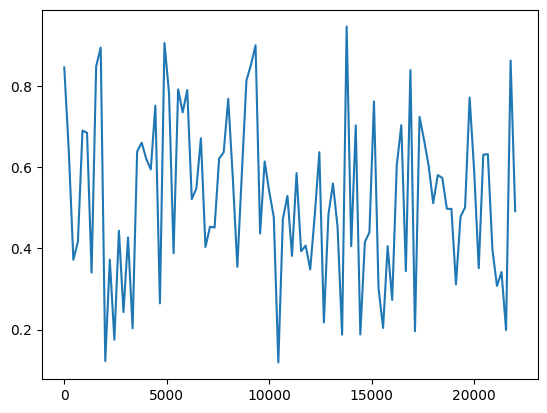

normal.wav


output.wav


In [9]:
#Setting up a random gθ
np.random.seed(411) #mess around with this seed and realize how good your ears are at immediately knowing the difference
eq = ParameterFunction()
b = np.random.uniform(0,1,eq.number_of_coefficients_needed())
eq.set_coefficients(b)

eq.graph()
EQ_FILE(f1, f2, eq)
show_audio_with_controls(f1)
show_audio_with_controls(f2)

## Finding f_X
This section demonstrates modelling our signal using the functionality of our f_X module.

In [12]:
#generate_long_white_noise
samplerate = 44100
duration = 3600 #1 hour of white noise
with AudioFile("1hrnormal.wav", "w", samplerate=samplerate, num_channels=1) as af:
    af.write(np.random.normal(0, 1, (1,samplerate*duration)))

In [13]:
#train our f_X distribution this might take a minute, depending on how many iterations you assign.
f = f_X()
f.audio_process("1hrnormal.wav")

In [17]:
g_inverse = lambda x: 1/g(x)
#this is our g inverse function. we need this to calculate the pdf of our transformed distribution.
#this is super invertable, because we EQ'd our file by multiplying by this, so we undo by dividing.

In [18]:
with AudioFile("1hrnormal.wav") as i:
    chunk = i.read(i.samplerate*0.02)[0]
    fft_result = np.fft.rfft(chunk)
    magnitude = np.abs(fft_result)
    print(f.log_pdf(np.array([magnitude])))

tensor([-4044.0171], grad_fn=<AddBackward0>)


How good is this representation? Well the best way to know is to just listen to the modelled signal, give the representation the "ear test".

In [15]:
fX_samples = f.sample_n(100)
with AudioFile("fX_sound.wav", "w", samplerate=samplerate, num_channels=1) as o:
    for sample in fX_samples:
        sample = sample.detach().numpy()
        signal = np.fft.irfft(sample)
        o.write(signal)
show_audio_with_controls("fX_sound.wav")
show_audio_with_controls("normal.wav")

fX_sound.wav


normal.wav


Sounds pretty similar, especially if you turn down volume of the normal signal so that the two have similar volume. The representation isn't quite perfect, but it's acceptably similar.

## Sampling using EQ_Finder

This final section outlines the sampling problem solved by the audioeqinfer **EQ_Finder** module. It extends our math above 

Clearly based on our modelling:
$$E[\theta|x'] = \int_{\Theta} \theta f_{\Theta|X'}(\theta|x') 

= \int_{\Theta} \theta \frac{f_X(g^{-1}_\theta(x')) f_\Theta (\theta)}{\int_\Theta { f_X(g_{ \theta_i}^{-1}(x')) f_\Theta (\theta)}}$$


Which suggests that we could sample from our observed signal and our parameter space, to develop more precise beliefs about the parameters of our EQ.

#### Importance sampling strategy

Outlining the theory behind `EQ_Finder.find_eq_importance`

We will further make some assumptions about $\theta$. Namely that all possible postive values between 0 and 1 are equally likely for each $\theta_i$ parameter. This assumption is definitely true for our example, since this is how we coded the randomization of the parameters of our EQ. Other prior assumptions may be better if you know more about the nature of the frequency distortions being applied.


This assumption makes $f_\Theta (\theta)$ a constant and suggests an appropriate approximation strategy for our expectation:

$$E[\theta|x'] \approx \frac{\sum_i \theta_i f_X(g_{ \theta_i}^{-1}(x'))}{\sum_i f_X(g_{ \theta_i}^{-1}(x'))}$$

We face two computational challenges in doing this:
1) x' can be arbitrarily big (because audiofiles are large) So we have to handle it in chunks. This is why EQ_finder's methods are all online algorithms.
2) f_X faces numeric underflow when exponentiating, because any given 20ms audio fft has extremely marginal probability, even if it's actually from the source signal. So we have to do our math in logspace.

Translating our information into logspace, and taking advantage of logsumexp (see: https://stackoverflow.com/questions/65233445/how-to-calculate-sums-in-log-space-without-underflow), we can translate this to:
$$\log E[\theta|x'] \approx \log [ LSE(\log (\theta_i) + \log f_X(g^{-1}_\theta(x'))) - LSE( \log g_\theta^{-1}(x') + \log f_X(g_{\theta}^{-1}(x'))) ]$$

#### Metropolis Hastings Algorithm

The above strategy is less than optimal for high dimensional `EQ_Finder.find_eq_mh` algorithm also uses the same log identities as above. 



In [45]:
#Create  the signal
EQ_FILE("1hrnormal.wav", "output.wav", g)

In [16]:
#found_coeffs = findr.find_eq("output.wav", 1000, 500)
findr = EQ_finder(f, eq.number_of_coefficients_needed())
found_coeffs_mh = findr.find_eq_MH("output.wav", 10000, burn_in = 10, keep_each = 1, std_dev = 0.01)

/home/widea/ProjectsWithOwnVenv/audioeqinfer/src/audioeqinfer/finder.py:137: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_alpha)


I'll save you the experience of running the importance sampling version of this function. It faces really high dimensionality, takes a long time, and is pretty bad. The biggest reason for that is that each individual 20ms audio sample is relatively low information about the total function. On the other hand, MH is fast, works really well, and yields great results. See below:

0.04506083921390681
0.0004003880286449614


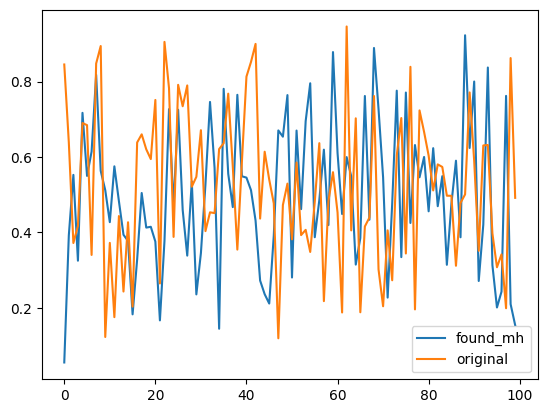

In [84]:
#print(np.abs(np.sum(eq.coefficients-found_coeffs))/len(eq.coefficients))
print(np.abs(np.sum(eq.coefficients-found_coeffs_mh))/len(eq.coefficients))
#foundeq = ParameterFunction()
foundmh = ParameterFunction()
#foundeq.set_coefficients(found_coeffs)
foundmh.set_coefficients(found_coeffs_mh)
plt.plot(foundmh.evaluate(np.linspace(0., 22000., 100)), label = "found_mh")
#plt.plot(foundeq.evaluate(np.linspace(0., 22000., 100)), label = "found_MH")
plt.plot(eq.evaluate(np.linspace(0., 22000., 100)), label = "original")

plt.legend()
plt.show()

## Conclusion:

And that's it! There are a number of extensions I hope to make in the future, including adding additional methods such as Hamiltonian Monte Carlo, and increasing expressiveness by allowing users to specify uneven distributions of fft basis frequencies in the EQ utility and parameter function.

Special thanks to Scott Schwartz for extensive office hours guidance throughout this project. And to Alex and Jae for being excellent study partners. I couldn't have made this project a semester ago, and now I can. Thank you.